# Automathon 2024

## Imports

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
import torchvision.io as io
import os
import json
from tqdm import tqdm
import csv
import timm
import wandb
import matplotlib.pyplot as plt

from PIL import Image
import torchvision.transforms as transforms

c:\Users\alber\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Utilities

In [4]:
dataset_dir = ".\\SomeEx"
video_files = [f for f in os.listdir(dataset_dir) if f.endswith('.mp4')]

videos = []

for video_name in video_files:
    print("Loading",video_name)
    video, audio, info = io.read_video(dataset_dir + "/" + video_name, pts_unit='sec')
    videos.append(video)
    
print("Done")


Loading actccqfmac.mp4
Loading agpzzhhprs.mp4
Loading balgkhiurl.mp4
Loading bgymmjkbec.mp4
Loading bkppzqmzdp.mp4
Loading cgjmjdenqi.mp4
Loading cjsopoykvh.mp4
Done


In [18]:
import torchvision

for i in range(1,4):

    frame = videos[5][20*i]
    nextframe = videos[5][20*i+1]
    img = np.array(nextframe - frame)

    plt.subplot(3,1,i)
    plt.imshow(img, cmap='gray') 

In [56]:
import matplotlib.animation
import matplotlib.pyplot as plt
import numpy as np
import torchvision

target_video = videos[1]
print("Video have",len(target_video),"frames")
NbFrames = 10

plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150  
plt.ioff()
fig, ax = plt.subplots()

x= np.linspace(0,10,100)
def animate(t):
    plt.cla()
    img = (target_video[t+1]-target_video[t])/target_video[t]
    img = np.array(img)
    img[:,:,0] = (img[:,:,0]+img[:,:,1]+img[:,:,2])/3
    img[:,:,1] = img[:,:,0]
    img[:,:,2] = img[:,:,0]

    min_ = np.min(img)
    max_ = np.max(img)

    img = img / np.linalg.norm(img, axis=-1)[:,:, np.newaxis]

    plt.imshow(img, cmap='gray')

matplotlib.animation.FuncAnimation(fig, animate, frames=NbFrames)

Video have 152 frames


C:\Users\alber\AppData\Local\Temp\ipykernel_1904\2905645638.py:27: RuntimeWarning: invalid value encountered in divide
  img = img / np.linalg.norm(img, axis=-1)[:,:, np.newaxis]


1104.8422191578966 7662.002490230875
1 / 30
2 / 30
3 / 30
4 / 30
5 / 30
6 / 30
7 / 30
8 / 30
9 / 30
10 / 30
11 / 30
12 / 30
13 / 30
14 / 30
15 / 30
16 / 30
17 / 30
18 / 30
19 / 30
20 / 30
21 / 30
22 / 30
23 / 30
24 / 30
25 / 30
26 / 30
27 / 30
28 / 30
29 / 30
30 / 30


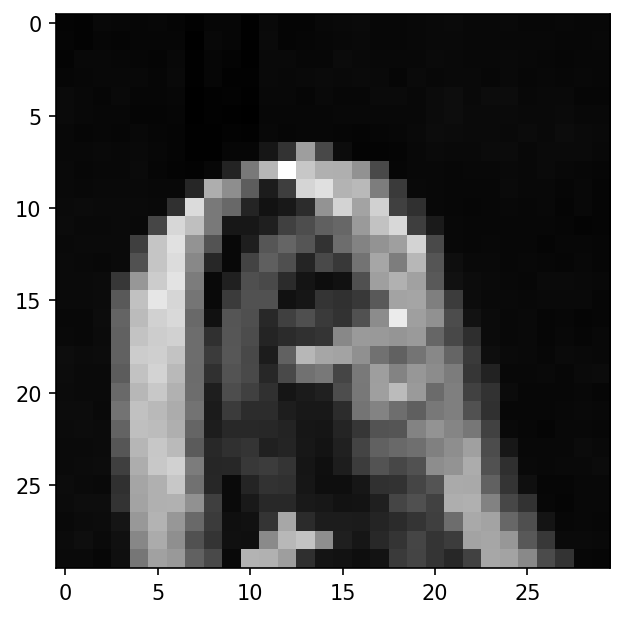

In [79]:

def getFFTat(x,y):
    pxvalues = np.array(target_video)[:,x,y,0]
    return np.abs(np.fft.fft(pxvalues))[20:140]

Y = np.array(target_video)[:,500,20,0]
Y2 = np.array(target_video)[:,300,680,0]

Y = np.abs(np.fft.fft(Y))[20:140]
Y2 = np.abs(np.fft.fft(Y2))[20:140]

print(np.sum(getFFTat(500,20)),np.sum(getFFTat(300,680)))

width = len(target_video[0])
height = len(target_video[0][0])

N = 30
Transform = np.zeros((N,N))

x_ = 0
y_ = 0

for x in np.linspace(200,400,N):
    for y in np.linspace(500,750,N):
        Transform[x_,y_] = np.sum(getFFTat(int(x),int(y)))
        y_ += 1
    y_ = 0
    x_ += 1
    print(x_,'/',N)


plt.imshow(Transform, cmap='gray')
plt.show()

In [ ]:
import matplotlib.animation
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150  
plt.ioff()
fig, ax = plt.subplots()

x= np.linspace(0,10,100)
def animate(t):
    plt.cla()
    plt.plot(x-t,x)
    plt.xlim(0,10)

matplotlib.animation.FuncAnimation(fig, animate, frames=10)

## Setup du Dataset

Voici comment afficher un frame du dataset:

Et comment faire un resize

## Modèle

In [ ]:
class DeepfakeDetector(nn.Module):
    def __init__(self, nb_frames=10):
        super().__init__()
        self.dense = nn.Linear(nb_frames*3*256*256,1)
        self.flat = nn.Flatten()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        y = self.flat(x)
        y = self.dense(y)
        y = self.sigmoid(y)
        return y


model = DeepfakeDetector(nb_frames=nb_frames)

video, label, ID = experimental_dataset[0]
video = video.unsqueeze(0) # add a batch dimension
summary(model, input_size=video.shape)

Layer (type:depth-idx)                   Output Shape              Param #
DeepfakeDetector                         [1, 1]                    --
├─Flatten: 1-1                           [1, 1966080]              --
├─Linear: 1-2                            [1, 1]                    1,966,081
├─BatchNorm1d: 1-3                       [1, 1]                    2
Total params: 1,966,083
Trainable params: 1,966,083
Non-trainable params: 0
Total mult-adds (M): 1.97
Input size (MB): 7.86
Forward/backward pass size (MB): 0.00
Params size (MB): 7.86
Estimated Total Size (MB): 15.73

## Logging

In [ ]:
wandb.login(key="a446d513570a79c857317c3000584c5f6d6224f0")

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [ ]:
run = wandb.init(
    project="automathon",
    name="nom-de-votre-equipe",
    config={
        "learning_rate": 0.001,
        "architecture": "-",
        "dataset": "DeepFake Detection Challenge",
        "epochs": 10,
        "batch_size": 10,
    },
)

## Entrainement

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

loss_fn = nn.MSELoss()
model = DeepfakeDetector().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
nb_epochs = 5
loader = DataLoader(experimental_dataset, batch_size=2, shuffle=True)

for epoch in range(nb_epochs):
    for sample in tqdm(loader, desc="Epoch {}".format(epoch), ncols=0):
        optimizer.zero_grad()
        X, label, ID = sample
        X = X.to(device)
        label = label.to(device)
        label_pred = model(X)
        label=torch.unsqueeze(label,dim=1)
        loss = loss_fn(label, label_pred)
        loss.backward()
        optimizer.step()
        run.log({"loss": loss.item(), "epoch": epoch})

Epoch 0:   2% 118/4957 [05:31<3:46:48,  2.81s/it]


KeyboardInterrupt: 

## Test

In [ ]:

loader = DataLoader(test_dataset, batch_size=2, shuffle=False)
model = model.to(device)
ids = []
labels = []
print("Testing...")
for sample in tqdm(loader):
    X, ID = sample
    #ID = ID[0]
    X = X.to(device)
    label_pred = model(X)
    ids.extend(list(ID))
    pred = (label_pred > 0.5).long()
    pred = pred.cpu().detach().numpy().tolist()
    labels.extend(pred)


 12%|█▏        | 66/557 [02:21<17:29,  2.14s/it]


IndexError: index 153 is out of bounds for dimension 0 with size 153

### Saving

In [ ]:
print("Saving...")
tests = ["id,label\n"] + [f"{ID},{label_pred[0]}\n" for ID, label_pred in zip(ids, labels)]
with open("submission.csv", "w") as file:
    file.writelines(tests)
